In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

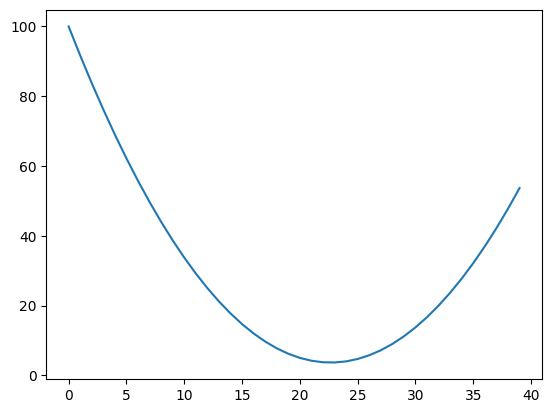

In [5]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(ys)

In [6]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [7]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [202]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return(out)
    
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = 'e'
# d = a*b + c
# d = a.__mul__(b).__add__(c)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = "L"

L

Value(data=-8.0)

In [151]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


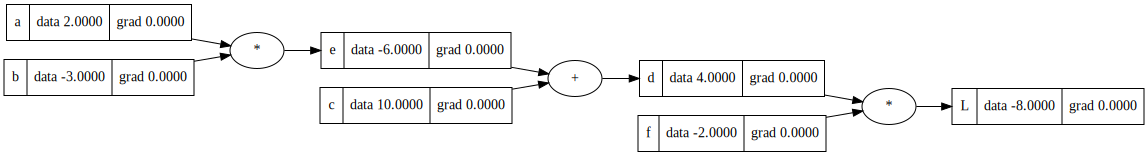

In [152]:
draw_dot(L)

In [155]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-8.0


In [156]:

a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [157]:
c.grad = -2.0
e.grad = -2.0 

In [158]:
# L = d * f
# dL/dd = f = -2.0
# (f(x+h) - f(x))/h
# ((d+h)*f - d*f)/h
# (d*f + f*h - d*f)/h
# f*h/h
# f

In [159]:
# dL/dc
# dL/de

# dd/dc = 1.0 # (local) derivative of sum is simple
# dd/de = 1.0

# d = c + e
# (f(x+h) - f(x))/h
# (c+h + e) - (c + e))/h
# (c + h + e - c - e)/h
# h/h
# 1.0


# chain rule (liebniz notatoin)
# dz/dx = dz/dy * dy/dx

# dL/dc =  dL/dd * dd/dc = -2.0 * 1.0 = -2.0


In [160]:
# dL / de = -2.0

# de/da = b = -3.0
#

# want: dL/da = (dL/de) * (dL/da)


In [161]:
f.grad = 4.0
d.grad = -2.0

In [162]:
def lol():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label = 'e'
    # d = a*b + c
    # d = a.__mul__(b).__add__(c)
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = "L"
    L1 = L.data
    
    a = Value(2.0 , label="a")
    b = Value(-3.0, label="b")
    b.data += h
    c = Value(10.0, label="c")
    e = a*b; e.label = 'e'
    # d = a*b + c
    # d = a.__mul__(b).__add__(c)
    d = e + c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = "L"
    L2 = L.data 
    
    print((L2 - L1)/h)

    

In [163]:
lol()

-4.000000000008441


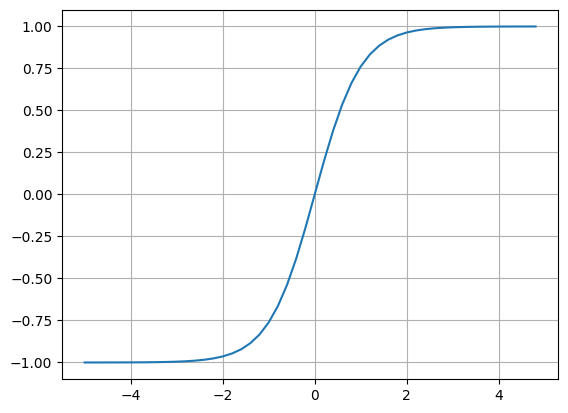

In [164]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [194]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

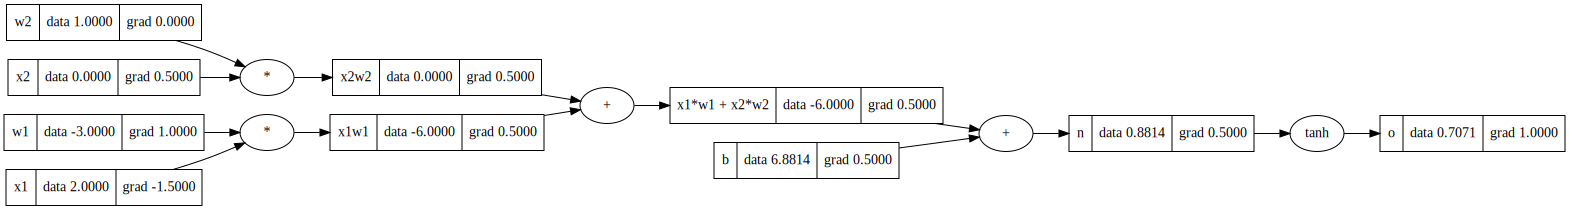

In [197]:
draw_dot(o)

In [196]:
o.backward()

In [188]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo


[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [179]:
o.grad = 1.0


In [180]:
o._backward()

In [181]:
n._backward()

In [182]:
b._backward()

In [184]:
x1w1x2w2._backward()

In [186]:
x2w2._backward()
x1w1._backward()

In [97]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [99]:
x2.grad = w2.data * x2w2.grad
w2.gard = x2.data * x2w2.grad

In [92]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [93]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [94]:
n.grad = 0.5

In [95]:
o.grad = 1.0

In [51]:
1 - o.data**2

0.4999999999999999

In [52]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2



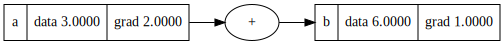

In [203]:
# bug
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
# overwriting a to be a (setting 1 to 1 again)

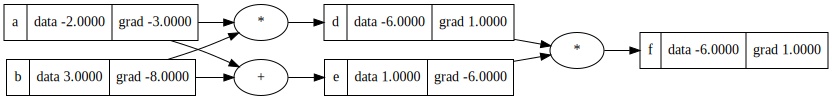

In [204]:
# another way to see this
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'

f.backward()

draw_dot(f)

In [ ]:
# we will have this problem every time we use a variable more than once
# solution: accumlate the gradient, instead of setting it